# Introduction


Hello everyone! Welcome to the second tutorial in the [Building models in JAX](https://github.com/AakashKumarNain/building_models_in_JAX) series. We will extend our [first tutorial](https://www.kaggle.com/aakashnain/building-models-in-jax-part1-stax/) where we used `Stax` to build a `CIFAR-10` classifier purely in JAX. This time we will use one of the most famous and most widely used high-level libraries for JAX for building a classifier. In this notebook, we will be taking a deep dive into **[Flax](https://flax.readthedocs.io/en/latest/)**. I will again list down all the things that we are going to do in this notebook: 

1. Use the Cifar-10 dataset for training the classifier
2. Build a classifier in Flax
3. Data augmentation purely in JAX
4. Create a custom training/testing loop in the most simplified manner
5. Discuss the pros and cons of this approach

If you don't know the fundamentals of TensorFlow/JAX, you can use these [notebooks](https://www.kaggle.com/general/296640) to get a solid understanding of both the frameworks. Without any further due, let's start!

In [1]:
import os
import warnings

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings("ignore")

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import cifar10

import jax
import jax.numpy as jnp
from jax import random
from jax import make_jaxpr
from jax.config import config
from jax import value_and_grad
from jax import grad, vmap, pmap, jit

import optax
from flax import linen as nn
from flax.training import train_state

np.random.seed(1234)
%config IPCompleter.use_jedi = False

# Dataset

We will use the Cifar-10 dataset for this experiment. You can download it or add it from Kaggle as well, but I am directly importing it from the available `tf.keras.datasets` for the sake of simplicity and brevity

In [3]:
# The downloaded dataset consists of two tuples. The first
# tuple represents the training data consisting of pairs of images
# and labels. Similary, the second tuple consists of validation/test data.
# I will use the second tuple as the validation data for this demo

(x_train, y_train), (x_valid, y_valid) = cifar10.load_data()
print(f"\nNumber of training samples: {len(x_train)} with samples shape: {x_train.shape[1:]}")
print(f"Number of validation samples: {len(x_valid)} with samples shape: {x_valid.shape[1:]}")


# There are 10 classes in this dataset. We will create a dictionary for
# mapping the names of the classes represented by the integer labels
# Labels dictionary
labels_dict = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}

170508288/170498071 [==============================] - 3s 0us/step

Number of training samples: 50000 with samples shape: (32, 32, 3)
Number of validation samples: 10000 with samples shape: (32, 32, 3)


# Plotting Utility

Whenever we deal with image data, a few steps related to data processing are always the same. The two most common of them are:
1. Check the raw image data and the corresponding labels to ensure that the labels are correct
2. Plot the augmented samples to ensure that the image augmentation pipeline is correct

Both the steps require the plotting of the samples. Hence, we will define a plotting utility to reuse for these steps.

In [4]:
def plot_samples(x, y, figsize=(12, 8), num_rows=5, num_columns=3, title=None):
    """Plots images with labels as desrciptons.
    
    Args:
        x: Batch of images represented as ndarray
        y: Batch of correspondning labels
        figsize: Plot size
        num_rows: Number of rows in the plot
        num_columns: Number of columns in the plot
        title: Title of the plot (if any). Defaults to `None`
    """
    
    if len(x) != len(y):
        raise ValueError("Number of images and number of labels don't match!")
    
    _, ax = plt.subplots(num_rows, num_columns, figsize=figsize)
    
    for i in range(num_rows * num_columns):
        try:
            img = x[i]
            label = str(y[i])
            ax[i // num_columns, i % num_columns].imshow(img)
            ax[i // num_columns, i % num_columns].set_title(label)
            ax[i // num_columns, i % num_columns].axis("off")
        except:
            pass
    
    if title:
        plt.suptitle(str(title))
    plt.show()

# Sanity Check

Now that we have our plotting utility, the first sanity check we will do is check the image data and the corresponding labels. To do so, we will perform the following steps:

1. We will randomly choose `n` numbers in the range `[0, len(training data) - 1]`
2. Based on the chosen indices, we will extract the images and the corresponding samples from the training data
3. Plot the randomly selected samples using our plotting utility for the sanity check

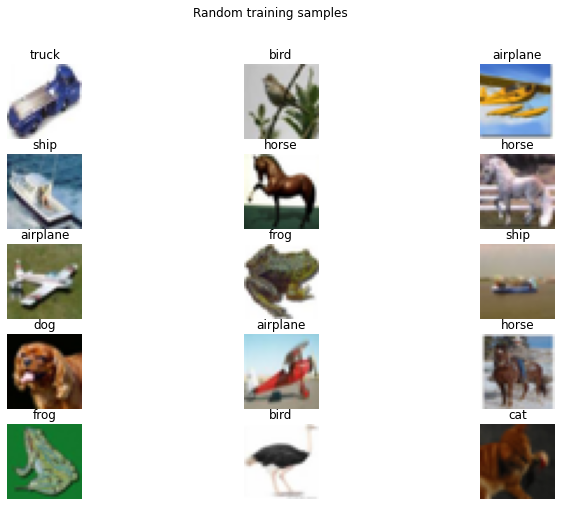

In [5]:
# Select random indices in the range [0, len(training_data) - 1]
sample_size = 15
indices = np.arange(len(x_train))
random_idx = np.random.choice(indices, size=(sample_size,))

# Get the data corresponding to the selected indices
randomly_selected_images = x_train[random_idx]
randomly_selected_labels = y_train[random_idx]

# We will map the integer labels to the class names using our labels dict
randomly_selected_labels = [labels_dict[i[0]] for i in randomly_selected_labels]

# Plot randomly selected samples to check the data
plot_samples(
    x=randomly_selected_images,
    y=randomly_selected_labels,
    title="Random training samples"
)

# Data Augmentation

We will apply image augmentation, and that too, purely in JAX. For augmentation, we will be using three different augmentation techniques:
1. Random rotation by 90 degrees
2. Random horizontal flips
3. Random vertical flips

For each of these augmentations:
1. We will define a function that will either return an augmented image or an identity image
2. Use [**vmap**](https://www.kaggle.com/aakashnain/tf-jax-tutorials-part-8-vmap-pmap#Data-Augmentation---Building-a-simple,-fast,-and-scalable-pipeline) to do augmentation in batches
3. [**jit**](https://www.kaggle.com/aakashnain/tf-jax-tutorials-part-7-jit-in-jax) the whole augmentation pipeline

In [6]:
def rotate_90(img):
    """Rotates an image by 90 degress k times."""
    return jnp.rot90(img, k=1, axes=(0, 1))


def identity(img):
    """Returns an image as it is."""
    return img


def flip_left_right(img):
    """Flips an image left/right direction."""
    return jnp.fliplr(img)


def flip_up_down(img):
    """Flips an image in up/down direction."""
    return jnp.flipud(img)


def random_rotate(img, rotate):
    """Randomly rotate an image by 90 degrees.
    
    Args:
        img: Array representing the image
        rotate: Boolean for rotating or not
    Returns:
        Rotated or an identity image
    """

    return jax.lax.cond(rotate, rotate_90, identity, img)


def random_horizontal_flip(img, flip):
    """Randomly flip an image vertically.
    
    Args:
        img: Array representing the image
        flip: Boolean for flipping or not
    Returns:
        Flipped or an identity image
    """
    
    return jax.lax.cond(flip, flip_left_right, identity, img)
    
    
def random_vertical_flip(img, flip):
    """Randomly flip an image vertically.
    
    Args:
        img: Array representing the image
        flip: Boolean for flipping or not
    Returns:
        Flipped or an identity image
    """
    
    return jax.lax.cond(flip, flip_up_down, identity, img)





# All the above function are written to work on a single example. 
# We will use `vmap` to get a version of these functions that can
# operate on a batch of images. We will also add the `jit` transformation
# on top of it so that the whole pipeline can be compiled and executed faster
random_rotate_jitted = jit(vmap(random_rotate, in_axes=(0, 0)))
random_horizontal_flip_jitted = jit(vmap(random_horizontal_flip, in_axes=(0, 0)))
random_vertical_flip_jitted = jit(vmap(random_vertical_flip, in_axes=(0, 0)))


def augment_images(images, key):
    """Augment a batch of input images.
    
    Args:
        images: Batch of input images as a jax array
        key: Seed/Key for random functions for generating booleans
    Returns:
        Augmented images with the same shape as the input images
    """
    
    batch_size = len(images)
    
    # 1. Rotation
    key, subkey = random.split(key)
    rotate = random.randint(key, shape=[batch_size], minval=0, maxval=2)
    augmented = random_rotate_jitted(images, rotate)
    
    # 2. Flip horizontally
    key, subkey = random.split(key)
    flip = random.randint(key, shape=[batch_size], minval=0, maxval=2)
    augmented = random_horizontal_flip_jitted(augmented, flip)
    
    # 3. Flip vertically
    key, subkey = random.split(key)
    flip = random.randint(key, shape=[batch_size], minval=0, maxval=2)
    augmented = random_vertical_flip_jitted(augmented, flip)
    
    return augmented

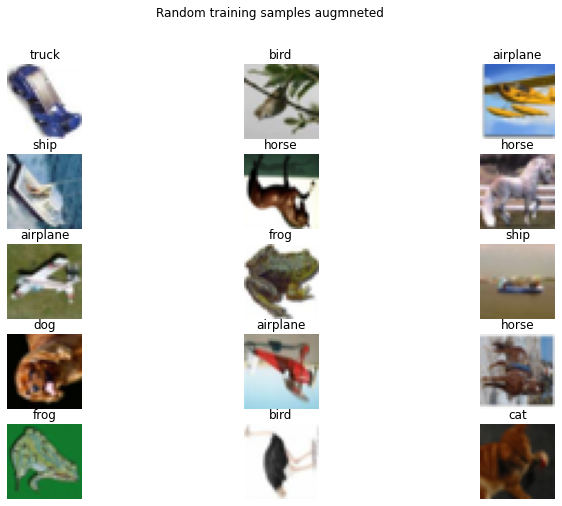

In [7]:
# Let's plot the augmented version of our randomly selected samples.
# This will help us ensure that our augmentation pipeline is working
# as expected.

# Augment the images we selected randomly
randomly_selected_images_augmented = augment_images(
    randomly_selected_images, key=random.PRNGKey(0)
)

# Plot the augmeneted samples
plot_samples(
    x=randomly_selected_images_augmented,
    y=randomly_selected_labels,
    title="Random training samples augmneted"
)

Perfect! The augmentation pipeline is working as expected. Let's move to the next step.

# Data Preprocessing

For data preprocessing, we will apply these two things:
1. We will normalize the image data so that the pixel values for each image is in the range `[0, 1]`
2. We will one-hot encode our labels

In [8]:
# Normalize the image pixels in the range [0, 1]
x_train_normalized = jnp.array(x_train / 255.)
x_valid_normalized = jnp.array(x_valid / 255.)

# One hot encoding applied to the labels. We have 10
# classes in the dataset, hence the depth of OHE would be 10
y_train_ohe = jnp.squeeze(jax.nn.one_hot(y_train, num_classes=10))
y_valid_ohe = jnp.squeeze(jax.nn.one_hot(y_valid, num_classes=10))

print(f"Training images shape:   {x_train_normalized.shape}  Labels shape: {y_train_ohe.shape}")
print(f"Validation images shape: {x_valid_normalized.shape}  Labels shape: {y_valid_ohe.shape}")

Training images shape:   (50000, 32, 32, 3)  Labels shape: (50000, 10)
Validation images shape: (10000, 32, 32, 3)  Labels shape: (10000, 10)


# Data Generator

Now that we have preprocessed our dataset, we need to define our data generator that will stream batches of data, where each batch is a pair of images and the corresponding labels. We will apply data augmentation to the training data only.

In [9]:
def data_generator(images, labels, batch_size=128, is_valid=False, key=None):
    """Generates batches of data from a given dataset.
    
    Args:
        images: Image data represented by a ndarray
        labels: One-hot enocded labels
        batch_size: Number of data points in a single batch
        is_valid: (Boolean) If validation data, then don't shuffle and
                    don't apply any augmentation
        key: PRNG key needed for augmentation
    Yields:
        Batches of images-labels pairs
    """
    
    # 1. Calculate the total number of batches
    num_batches = int(np.ceil(len(images) / batch_size))
    
    # 2. Get the indices and shuffle them
    indices = np.arange(len(images))
    
    if not is_valid:
        if key is None:
             raise ValueError("A PRNG key is required if `aug` is set to True")
        else:
            np.random.shuffle(indices)
    
    for batch in range(num_batches):
        curr_idx = indices[batch * batch_size: (batch+1) * batch_size]
        batch_images = images[curr_idx]
        batch_labels = labels[curr_idx]
        
        if not is_valid: 
            batch_images = augment_images(batch_images, key=key)
        yield batch_images, batch_labels
        
        

# Sanity Check: To make sure that the batches generated by the data
# generator are of correct size, we will just pull a batch of data and
# will check the shape of the images and the labels

sample_data_gen = data_generator(
    images=x_train_normalized,
    labels=y_train_ohe,
    batch_size=8,
    is_valid=False,
    key=random.PRNGKey(0)
)

sample_batch_images, sample_batch_labels = next(sample_data_gen)
print("Batch of images is of shape: ", sample_batch_images.shape)
print("Batch of labels is of shape: ", sample_batch_labels.shape)

# Clean up unnecessary objects
del sample_data_gen, sample_batch_images, sample_batch_labels

Batch of images is of shape:  (8, 32, 32, 3)
Batch of labels is of shape:  (8, 10)


# Model

This time we will be using Flax to build our CNN model. The API design for Flax deserves a separate discussion (which I probably will do on [Twitter](https://twitter.com/A_K_Nain)). Here I will list the basic things that you need to know to build neural networks in Flax.

1. [Module](https://flax.readthedocs.io/en/latest/flax.linen.html#flax.linen.Module) is the base class for building NNs in Flax. You need to inherit this class for writing layers or models.
2. Modules can have submodules e.g. a bunch of layers inside a model. There are two ways to define submodules. The first one is to declare them by overriding the`setup(...)` method and then calling them inside the `__call__(...)` method, much like how you do in Tensorflow custom models and in Pytorch. The second one is to directly declare and call the submodules in the `__call__(...)` method by decorating it with the `@nn.compact` decorator. Both the approaches have their pros and cons, and you **should** read [this](https://flax.readthedocs.io/en/latest/design_notes/setup_or_nncompact.html) to understand it in detail.
3. Once the model is defined, we will then define:
    * The loss function
    * The evaluation metric
    * Train step
    * Test step
    * Training and evaluation loops
    

**Note:** Please read the code comments in the next section carefully. They will help you understand the above steps in detail.

In [10]:
# A. Model defintion

# Inherit the Module class for building the neural network
class CifarCNN(nn.Module):
    """CIFAR-10 Classifier"""
    
    # We will be using the `nn.compact` decorator to decorate our __call__() method
    # Some people may find it very implicit and confusing, and if you do please define
    # your submodules (layers in this case) in the `setup(...)` method and then call
    # them in the `__call(...)__` method.
    
    @nn.compact
    def __call__(self, x):
        # First conv block
        x = nn.Conv(32, (3, 3), padding="SAME")(x)
        x = nn.relu(x)
        x = nn.max_pool(x, (2, 2), (2, 2))
        
        # Second conv block
        x = nn.Conv(64, (3, 3), padding="SAME")(x)
        x = nn.relu(x)
        x = nn.max_pool(x, (2, 2), (2, 2))
        
        # Third conv block
        x = nn.Conv(128, (3, 3), padding="SAME")(x)
        x = nn.relu(x)
        x = nn.max_pool(x, (2, 2), (2, 2))
        
        # Flatten 
        x = x.reshape(x.shape[0], -1)
        
        # Dense layers
        x = nn.Dense(256)(x)
        x = nn.relu(x)
        
        # We are going to return the logits and not
        # the softamx activations 
        x = nn.Dense(10)(x)
        return x
    


# B. Loss function we want to use for the optimization
def calculate_loss(params, inputs, labels):
    """Cross-Entropy loss function.
    
    Args:
        params: The parameters of the model at the current step
        inputs: Batch of images
        labels: Batch of corresponding labels    
    Returns:
        loss: Mean loss value for the current batch
        logits: Output of the last layer of the classifier
    """
    logits = CifarCNN().apply({'params': params}, inputs)
    loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=labels))
    return loss, logits



# C. Evaluation metric
def calculate_accuracy(logits, labels):
    """Computes accuracy for a given batch.
    
    Args:
        logits: Output of the last layer of the classifier
        labels: Batch of corresponding labels    
    Returns:
        Mean accuracy for the current batch
    """
    return jnp.mean(jnp.argmax(logits, -1) == jnp.argmax(labels, -1))
    

# D. Train step. We will `jit` transform it to compile it. We will get a 
# good speedup on the subseuqent runs
@jax.jit
def train_step(state, batch_data):
    """Defines the single training step.
    
    Args:
        state: Current `TrainState` of the model
        batch_data: Tuple containingm a batch of images and their corresponding labels
    Returns:
        loss: Mean loss for the current batch
        accuracy: Mean accuracy for the current batch
        state: Updated state of the model
    """
    
    # 1. Get the images and the labels
    inputs, labels = batch_data

    # 2. Calculate the loss and get the gradients
    (loss, logits), grads = jax.value_and_grad(calculate_loss, has_aux=True)(state.params, inputs, labels)
    
    # 3. Calculate the accuracy for the cuurent batch
    accuracy = calculate_accuracy(logits, labels)
    
    # 4. Update the state (parameters values) of the model
    state = state.apply_gradients(grads=grads)
    
    # 5. Return loss, accuracy and the updated state
    return loss, accuracy, state



# E. Test/Evaluation step. We will `jit` transform it to compile it as well.
@jax.jit
def test_step(state, batch_data):
    """Defines the single test/evaluation step.
    
    Args:
        state: Current `TrainState` of the model
        batch_data: Tuple containingm a batch of images and their corresponding labels
    Returns:
        loss: Mean loss for the current batch
        accuracy: Mean accuracy for the current batch
    """
    # 1. Get the images and the labels
    inputs, labels = batch_data
    
    # 2. Calculate the loss
    loss, logits = calculate_loss(state.params, inputs, labels)
    
    # 3. Calculate the accuracy
    accuracy = calculate_accuracy(logits, labels)
    
    # 4. Return loss and accuracy values
    return loss, accuracy
    

# F. Initial train state including parameters initialization
def create_train_state(key, lr=1e-4):
    """Creates initial `TrainState for our classifier.
    
    Args:
        key: PRNG key to initialize the model parameters
        lr: Learning rate for the optimizer
    
    """
    # 1. Model instance
    model = CifarCNN()
    
    # 2. Initialize the parameters of the model
    params = model.init(key, jnp.ones([1, 32, 32, 3]))['params']
    
    # 3. Define the optimizer with the desired learning rate
    optimizer = optax.adam(learning_rate=lr)
    
    # 4. Create and return initial state from the above information. The `Module.apply` applies a 
    # module method to variables and returns output and modified variables.
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=optimizer)

# Training

We have coded every piece required for training and evaluation. We will now define our training loop. 

In [11]:
EPOCHS = 50
BATCH_SIZE = 128


key = random.PRNGKey(0)

key, init_key = random.split(key)
state = create_train_state(init_key)

# Lists to record loss and accuracy for each epoch
training_loss = []
validation_loss = []
training_accuracy = []
validation_accuracy = []

# Training 
for i in range(EPOCHS):
    num_train_batches = len(x_train) // BATCH_SIZE
    num_valid_batches = len(x_valid) // BATCH_SIZE
    
    # Lists to store loss and accuracy for each batch
    train_batch_loss, train_batch_acc = [], []
    valid_batch_loss, valid_batch_acc = [], []
    
    # Key to be passed to the data generator for augmenting
    # training dataset
    key, subkey = random.split(key)
    
    # Initialize data generators
    train_data_gen = data_generator(x_train_normalized,
                                y_train_ohe,
                                batch_size=BATCH_SIZE,
                                is_valid=False,
                                key=key
                               )

    valid_data_gen = data_generator(x_valid_normalized,
                               y_valid_ohe,
                               batch_size=BATCH_SIZE,
                               is_valid=True
                               )
    
    print(f"Epoch: {i+1:<3}", end=" ")
    
    # Training
    for step in range(num_train_batches):
        batch_data = next(train_data_gen)
        loss_value, acc, state = train_step(state, batch_data)
        train_batch_loss.append(loss_value)
        train_batch_acc.append(acc)
    
    # Evaluation on validation data
    for step in range(num_valid_batches):
        batch_data = next(valid_data_gen)
        loss_value, acc = test_step(state, batch_data)
        valid_batch_loss.append(loss_value)
        valid_batch_acc.append(acc)
    
    # Loss for the current epoch
    epoch_train_loss = np.mean(train_batch_loss)
    epoch_valid_loss = np.mean(valid_batch_loss)
    
    # Accuracy for the current epoch
    epoch_train_acc = np.mean(train_batch_acc)
    epoch_valid_acc = np.mean(valid_batch_acc)
    
    training_loss.append(epoch_train_loss)
    training_accuracy.append(epoch_train_acc)
    validation_loss.append(epoch_valid_loss)
    validation_accuracy.append(epoch_valid_acc)
    
    print(f"loss: {epoch_train_loss:.3f}   acc: {epoch_train_acc:.3f}  valid_loss: {epoch_valid_loss:.3f}  valid_acc: {epoch_valid_acc:.3f}")

Epoch: 1   loss: 1.985   acc: 0.290  valid_loss: 1.820  valid_acc: 0.345
Epoch: 2   loss: 1.745   acc: 0.376  valid_loss: 1.696  valid_acc: 0.389
Epoch: 3   loss: 1.646   acc: 0.410  valid_loss: 1.576  valid_acc: 0.435
Epoch: 4   loss: 1.581   acc: 0.437  valid_loss: 1.539  valid_acc: 0.455
Epoch: 5   loss: 1.522   acc: 0.457  valid_loss: 1.488  valid_acc: 0.469
Epoch: 6   loss: 1.482   acc: 0.471  valid_loss: 1.444  valid_acc: 0.487
Epoch: 7   loss: 1.448   acc: 0.485  valid_loss: 1.449  valid_acc: 0.487
Epoch: 8   loss: 1.416   acc: 0.495  valid_loss: 1.380  valid_acc: 0.509
Epoch: 9   loss: 1.396   acc: 0.500  valid_loss: 1.377  valid_acc: 0.514
Epoch: 10  loss: 1.373   acc: 0.512  valid_loss: 1.352  valid_acc: 0.520
Epoch: 11  loss: 1.352   acc: 0.521  valid_loss: 1.334  valid_acc: 0.527
Epoch: 12  loss: 1.331   acc: 0.528  valid_loss: 1.320  valid_acc: 0.529
Epoch: 13  loss: 1.328   acc: 0.530  valid_loss: 1.309  valid_acc: 0.538
Epoch: 14  loss: 1.302   acc: 0.538  valid_loss: 1.

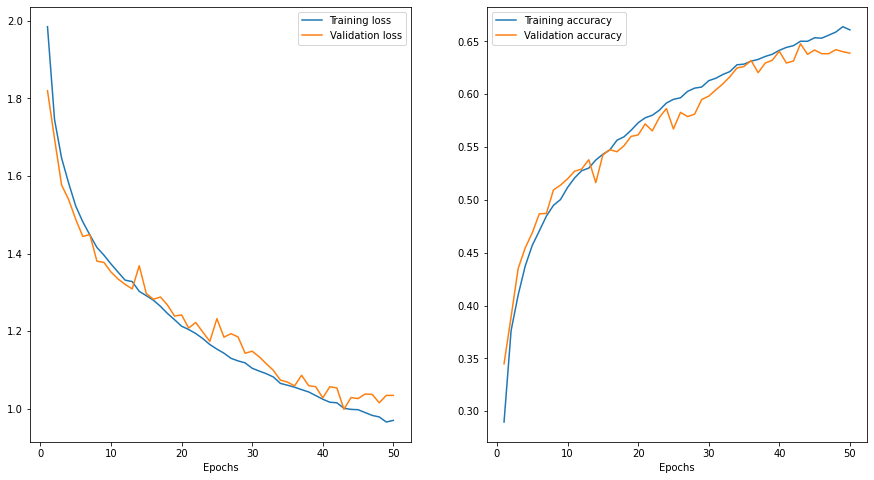

In [12]:
# Let's plot the training and validataion losses as well as
# accuracies for both the dataset. 

_, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].plot(range(1, EPOCHS+1), training_loss)
ax[0].plot(range(1, EPOCHS+1), validation_loss)
ax[0].set_xlabel("Epochs")
ax[0].legend(["Training loss", "Validation loss"])

ax[1].plot(range(1, EPOCHS+1), training_accuracy)
ax[1].plot(range(1, EPOCHS+1), validation_accuracy)
ax[1].set_xlabel("Epochs")
ax[1].legend(["Training accuracy", "Validation accuracy"])

plt.show()

# Evaluation

Let's take a batch of random samples from the validation data. Check how many of them we can predict correctly, and let's plot the images in the selected batch, along with the predicted labels for the same.

Accuracy on randomly selected sample of size 16 is 75.00 %



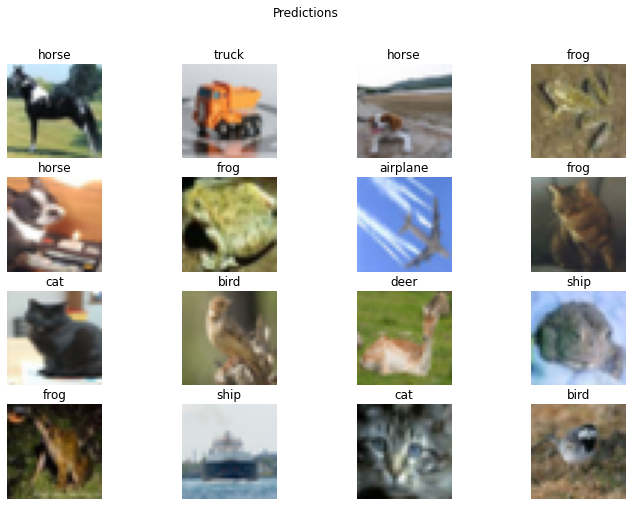

In [13]:
# Select some samples randomly from the validation data
np.random.seed(0)
random_idx = np.random.choice(np.arange(len(x_valid_normalized)), size=16)
random_valid_samples = x_valid_normalized[random_idx], y_valid_ohe[random_idx]

# Get the predictions
logits = CifarCNN().apply({'params': state.params}, random_valid_samples[0])

# Calculate the accuracy for these samples
acc = calculate_accuracy(logits, random_valid_samples[1])
predicted_class = np.asarray(jnp.argmax(logits, -1))

# Map the predicted class to the original class names
predicted_class = [labels_dict[pred] for pred in predicted_class]

# Plot the samples along with the predictions
print(f"Accuracy on randomly selected sample of size {len(random_idx)} is {acc*100:.2f} %\n")
plot_samples(x=x_valid[random_idx], y=predicted_class, num_rows=4, num_columns=4, title="Predictions")

# Pros and Cons

Now that we have built a classifier in Flax, let's talk about the pros and cons of this approach.

## Pros
1. Among all the high-level APIs floating around, Flax is relatively more stable, easy to use, and widely adopted, and has a good community support
2. Building models in Flax is almost similar to building models in Pytorch/TF, so porting models from those frameworks to JAX using Flax will be relatively easy
3. The philosophy of Flax is to provide a minimal abstraction that is easy to use and easier to extend. A bad abstraction is worse than no abstraction. And I am aligned with both these points

## Cons
1. Creation of initial train state should be a method of the `Module(...)` class. Doing that serves two purposes:
    * We don't need to instantiate the model separately for initializing params. The first call to the model should check if the train state has been instantiated, and if not, it should call that method to initialize the model parameters.
    * If we do the above, it becomes easier to inspect the input/output shapes of the submodules and possibly summarize them in a pretty tabular format as done in Keras
2. If your module has submodules that need a `PRNG` key, e.g. `Dropout`, then we need to pass a list of `PRNG` keys. Ideally, the `PRNG` should be passed at the `Module` level, and then it should be split and used for all the other submodules that require a seed.
3. `@nn.compact` can be confusing for beginners. If we go by `Explicit is better than implicit`, then overriding `setup(...)` makes more sense, but in some cases, it is problematic as well. Check [this](https://flax.readthedocs.io/en/latest/design_notes/arguments.html?highlight=dropout#solution) usage as an example.


I hope you enjoyed the tutorial! Please let me know in the comments section if you have any questions/feedback.


# References
1. https://jax.readthedocs.io/en/latest/
2. https://www.cs.toronto.edu/~kriz/cifar.html
3. https://keras.io/
4. https://flax.readthedocs.io/en/latest/